# Create SageMaker Models Using the PyTorch Model Zoo

In this example, we use a YOLO object detection model from the Ultralytics to create bounding boxes for pre-defined object classes.

This notebook showcases an end-to-end example, from loading the object detection model weights, saving them to an S3 bucket, to writing an entrypoint file and understanding the key parameters in the SageMaker PyTorchModel API. Finally we deploy the model, perform ML model inference, and view the model output and learn how to interpret the results.  Additionally we will add autoscaling to the endpoint


## Imports

In [2]:
%pip install --upgrade pip
%pip install --upgrade sagemaker
%pip install ultralytics
%pip install opencv-python-headless

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
import os, sagemaker, subprocess, boto3, cv2, time, random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sagemaker import s3
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorchModel
from sagemaker.deserializers import JSONDeserializer
from sagemaker.pytorch import PyTorchPredictor
from sagemaker.serializers import DataSerializer
from ultralytics import YOLO

## Step 1: Setup

In [4]:
sagemaker_session = sagemaker.Session()

# Set a default S3 bucket
default_bucket = sagemaker_session.default_bucket()

# Get the current AWS region
aws_region = boto3.Session().region_name

# Get the SageMaker Execution Role
role_arn = sagemaker.get_execution_role()

BUCKET = os.path.join("s3://", default_bucket)
SAGEMAKER_EXECUTION_ROLE_ARN = role_arn
MODEL_ARTIFACTS_FILE_NAME = os.path.join(BUCKET, "modelzoo/yolov8n/model.tar.gz")

## Step 2: Loading an ML Model from the artifacts

Next we define an object detection model and save the model weights. 

In [12]:
## Choose a model:
model_name = 'yolov8n.pt'

model = YOLO(model_name)
bashCommand = f"tar -cpzf  model.tar.gz {model_name}"
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

## Step 3: Save and Upload Model Artifacts to S3

Since we use Amazon SageMaker for inference, we need to upload the model weights to an S3 bucket. We can do so with the command below, or by downloading and simply dragging and dropping the file directly into S3. We first package the group of files within model.pt to an archive and copy the model weights in `model.tar.gz` from the local machine to the S3 bucket.

In [6]:
!aws s3 cp model.tar.gz $MODEL_ARTIFACTS_FILE_NAME

upload: ./model.tar.gz to s3://sagemaker-us-east-1-431615879134/modelzoo/yolov8n/model.tar.gz


## Step 4: Building ML Model Inference Scripts
Now we go over our entrypoint file `inference.py`. We can deploy a PyTorch model trained outside of SageMaker by using the *PyTorchModel* class. First we construct an `inference.py` entrypoint file to perform inference using SageMaker on sample data hosted in S3.

Our model artifacts (model checkpoint) referenced by the `model_data` parameter in `PyTorchModel` are loaded from S3 and packaged as part of the SageMaker model docker image. In order to use the trained ML model for serving, we need to instruct the *PyTorchModel* class how to a recover a PyTorch model from the static checkpoint. This deployed endpoint also interacts with REST API calls, we need to tell it how to parse an incoming request to the model. These instructions need to be defined in the entrypoint file.

The *entry_point* parameter references a python file named `inference.py`. It defines model loading, input data preprocessing, ML model prediction logic, and output post-processing.

`inference.py` contains the following functions. In our example, we implement the `model_fn`, `input_fn`, `predict_fn` and `output_fn` functions to override the default [PyTorch inference handler](https://github.com/aws/sagemaker-pytorch-inference-toolkit/blob/master/src/sagemaker_pytorch_serving_container/default_pytorch_inference_handler.py).

1. `model_fn`: Takes in a directory containing static model checkpoints in the inference image. Opens and loads the model from a specified path, and returns a *PyTorch model*.
2. `input_fn`: Takes in the payload of the incoming request (*request_body*) and the content type of an upcoming request (*request_content_type*) as input. Handles data decoding. This function that needs to be adjusted for what input the model is expecting
3. `predict_fn`: Calls a model on data deserialized in `input_fn`. Perform prediction on the deserialized object, with the loaded model.
4. `output_fn`: Serialize the prediction result into the desired response content type. Serializes predictions from `predict_fn` to JSON, CSV or NPY format.

The `inference.py` script is used as an input to the Sagemaker deployment. 


In [7]:
model = PyTorchModel(entry_point='inference.py',
                     source_dir='./code',
                     model_data=MODEL_ARTIFACTS_FILE_NAME, 
                     framework_version='1.12', 
                     py_version='py38',
                     role=role_arn,
                     env={'TS_MAX_RESPONSE_SIZE':'20000000', 'YOLOV8_MODEL': model_name})


## Step 5: Deploy Real Time Endpoint

In [10]:
INSTANCE_TYPE = 'ml.m5.4xlarge'
ENDPOINT_NAME = 'yolov8-pytorch-' + str(datetime.utcnow().strftime('%Y-%m-%d-%H-%M-%S-%f'))

# Store the endpoint name in the history to be accessed by 2_TestEndpoint.ipynb notebook
%store ENDPOINT_NAME
print(f'Endpoint Name: {ENDPOINT_NAME}')

predictor = model.deploy(initial_instance_count=1, 
                         instance_type=INSTANCE_TYPE,
                         deserializer=JSONDeserializer(),
                         serializer=DataSerializer(content_type="image/jpg"),
                         endpoint_name=ENDPOINT_NAME)

Stored 'ENDPOINT_NAME' (str)
Endpoint Name: yolov8-pytorch-2024-04-24-19-47-13-204435
-------!

## Step 6: Visualizing Results

The model outputs bounding boxes with confidence scores. Finally, we visualize these mappings to understand our output in a more meaningful way. 

In [11]:
predictor = PyTorchPredictor(endpoint_name=ENDPOINT_NAME,
                             deserializer=JSONDeserializer(),
                             serializer=DataSerializer(content_type="image/jpg"))

In [14]:
# generate color mapping 

# Dictionary to hold colors for each class
class_colors = {}
for lbl in model.names:
    # Check if the class color already exists; if not, create it
    if lbl not in class_colors:
        # Assign a random but consistent color for each class
        class_colors[lbl] = (random.randint(10, 255), random.randint(10, 255), random.randint(10, 255))


Inference Time = 1.9365 seconds


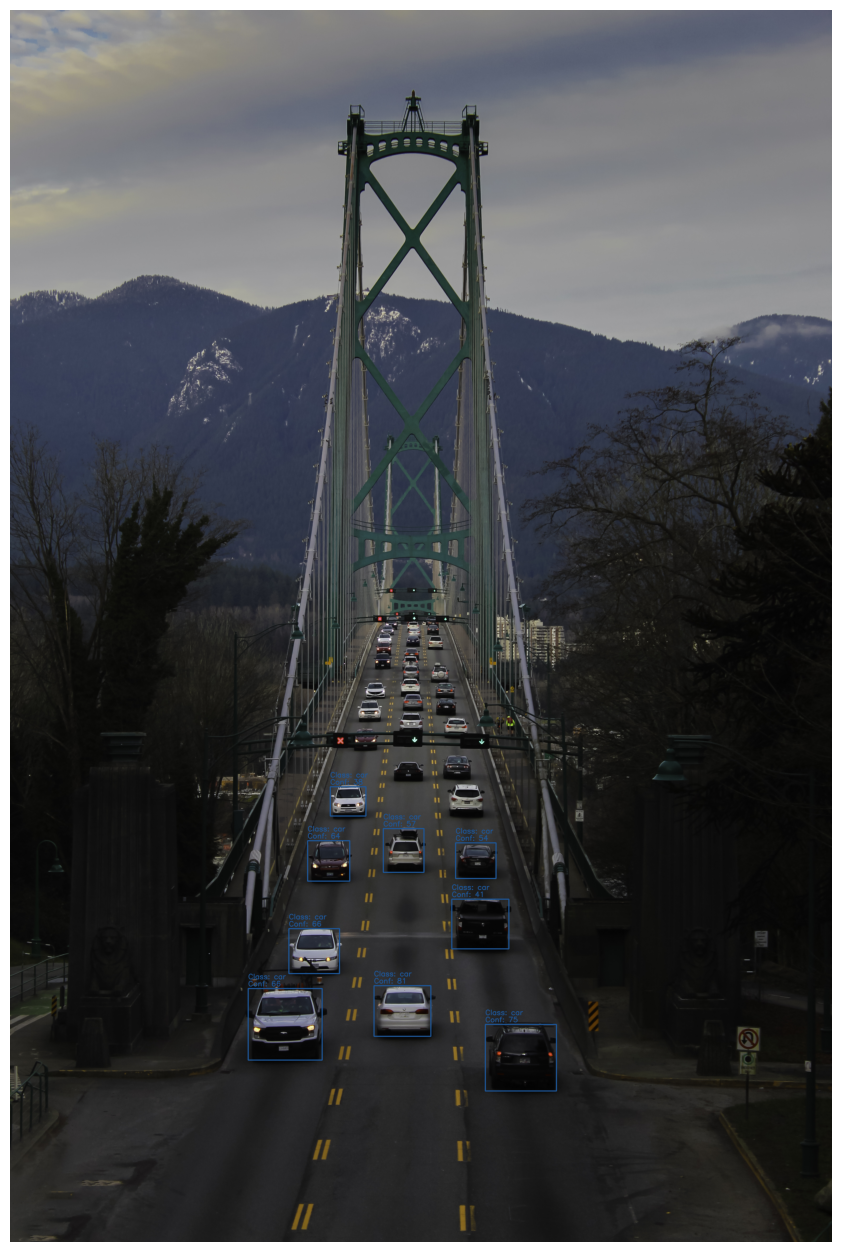

In [15]:
infer_start_time = time.time()

orig_image = cv2.imread('cars.jpg')
payload = cv2.imencode('.jpg', orig_image)[1].tobytes()
results = predictor.predict(payload,)

infer_end_time = time.time()

print(f"Inference Time = {infer_end_time - infer_start_time:0.4f} seconds")

for result in results:
    box = result["box"]
    lbl = result["name"]
    classint = result["class"]
    conf = result["confidence"]
    x1, y1, x2, y2 = int(box["x1"]), int(box["y1"]), int(box["x2"]), int(box["y2"])
    color = class_colors[classint]
    cv2.rectangle(orig_image, (x1,y1), (x2,y2), color, 4)
    cv2.putText(orig_image, f"Class: {lbl}", (x1,y1-40), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    cv2.putText(orig_image, f"Conf: {int(conf*100)}", (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    
# Create a new figure with specified size
plt.figure(figsize=(30, 16))  # You can adjust the size as needed    
plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
# Turn off the axis
plt.axis('off')
plt.savefig('result.jpg', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

## Step 7: Auto Scale the Endpoint!

In [19]:
# check number of instances on the endpoint
bt_sm = boto3.client('sagemaker')
response = bt_sm.describe_endpoint(EndpointName=predictor.endpoint_name)
print(f"Endpoint {response['EndpointName']} has \nCurrent Instance Count: {response['ProductionVariants'][0]['CurrentInstanceCount']}\nWith a desired instance count of {response['ProductionVariants'][0]['DesiredInstanceCount']}")

Endpoint yolov8-pytorch-2024-04-24-19-47-13-204435 has 
Current Instance Count: 1
With a desired instance count of 1


In [21]:
print(f"https://console.aws.amazon.com/cloudwatch/home?region={aws_region}#metricsV2:graph=~(metrics~(~(~'AWS*2fSageMaker~'InvocationsPerInstance~'EndpointName~'{predictor.endpoint_name}~'VariantName~'AllTraffic))~view~'timeSeries~stacked~false~region~'{aws_region}~start~'-PT15M~end~'P0D~stat~'SampleCount~period~60);query=~'*7bAWS*2fSageMaker*2cEndpointName*2cVariantName*7d*20{predictor.endpoint_name}")

https://console.aws.amazon.com/cloudwatch/home?region=us-east-1#metricsV2:graph=~(metrics~(~(~'AWS*2fSageMaker~'InvocationsPerInstance~'EndpointName~'yolov8-pytorch-2024-04-24-19-47-13-204435~'VariantName~'AllTraffic))~view~'timeSeries~stacked~false~region~'us-east-1~start~'-PT15M~end~'P0D~stat~'SampleCount~period~60);query=~'*7bAWS*2fSageMaker*2cEndpointName*2cVariantName*7d*20yolov8-pytorch-2024-04-24-19-47-13-204435


In [22]:
# application-autoscaling client
asg_client = boto3.client("application-autoscaling")

# This is the format in which application autoscaling references the endpoint
resource_id = f"endpoint/{predictor.endpoint_name}/variant/AllTraffic"

# Configure Autoscaling on asynchronous endpoint down to zero instances
response = asg_client.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=1,
    MaxCapacity=3,
)

response = asg_client.put_scaling_policy(
    PolicyName=f'Request-ScalingPolicy-{predictor.endpoint_name}',
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    PolicyType="TargetTrackingScaling",
    TargetTrackingScalingPolicyConfiguration={
        'TargetValue': 10.0, # Threshold
        'PredefinedMetricSpecification': {
            'PredefinedMetricType': 'SageMakerVariantInvocationsPerInstance',
        },
        'ScaleInCooldown': 300, # duration until scale in
        'ScaleOutCooldown': 60 # duration between scale out
    }
)


In [23]:
request_duration_in_seconds = 4*65
end_time = time.time() + request_duration_in_seconds

print(f"test will run {request_duration_in_seconds} seconds")

orig_image = cv2.imread('cars.jpg')
payload = cv2.imencode('.jpg', orig_image)[1].tobytes()

while time.time() < end_time:
    result = predictor.predict(payload,)

test will run 260 seconds


In [21]:
print(f"https://console.aws.amazon.com/cloudwatch/home?region={aws_region}#metricsV2:graph=~(metrics~(~(~'AWS*2fSageMaker~'InvocationsPerInstance~'EndpointName~'{predictor.endpoint_name}~'VariantName~'AllTraffic))~view~'timeSeries~stacked~false~region~'{aws_region}~start~'-PT15M~end~'P0D~stat~'SampleCount~period~60);query=~'*7bAWS*2fSageMaker*2cEndpointName*2cVariantName*7d*20{predictor.endpoint_name}")

https://console.aws.amazon.com/cloudwatch/home?region=us-east-1#metricsV2:graph=~(metrics~(~(~'AWS*2fSageMaker~'InvocationsPerInstance~'EndpointName~'yolov8-pytorch-2024-04-24-19-47-13-204435~'VariantName~'AllTraffic))~view~'timeSeries~stacked~false~region~'us-east-1~start~'-PT15M~end~'P0D~stat~'SampleCount~period~60);query=~'*7bAWS*2fSageMaker*2cEndpointName*2cVariantName*7d*20yolov8-pytorch-2024-04-24-19-47-13-204435


In [30]:
bt_sm = boto3.client('sagemaker')
response = bt_sm.describe_endpoint(EndpointName=predictor.endpoint_name)
print(f"Endpoint {response['EndpointName']} has \nCurrent Instance Count: {response['ProductionVariants'][0]['CurrentInstanceCount']}\nWith a desired instance count of {response['ProductionVariants'][0]['DesiredInstanceCount']}")

Endpoint yolov8-pytorch-2024-04-24-19-47-13-204435 has 
Current Instance Count: 3
With a desired instance count of 3


## Step 8: Update Endpoint

In [ ]:
MODEL_ARTIFACTS_FILE_NAME = os.path.join(BUCKET, "modelzoo/yolov8l/model.tar.gz")

## Choose a model:
model_name = 'yolov8l.pt'

model = YOLO(model_name)

bashCommand = f"tar -cpzf  model.tar.gz {model_name}"
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

In [ ]:
!aws s3 cp model.tar.gz $MODEL_ARTIFACTS_FILE_NAME

In [ ]:
model = PyTorchModel(entry_point='inference.py',
                     source_dir='./code',
                     model_data=MODEL_ARTIFACTS_FILE_NAME, 
                     framework_version='1.12', 
                     py_version='py38',
                     role=role_arn,
                     env={'TS_MAX_RESPONSE_SIZE':'20000000', 'YOLOV8_MODEL': model_name})

In [ ]:
model.register(inference_instances=[INSTANCE_TYPE])

In [ ]:
new_config = sagemaker

## Step 9: Clean Up

In [28]:
response = asg_client.deregister_scalable_target(
    ServiceNamespace='sagemaker',
    ResourceId=resource_id,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount'
)


In [31]:
predictor.delete_endpoint()

ClientError: An error occurred (ValidationException) when calling the DeleteEndpointConfig operation: Could not find endpoint configuration "yolov8-pytorch-2024-04-24-19-47-13-204435".

## Summary

In this example, we walked through an end-to-end example for performing ML model inference using an object detection model using SageMaker . We covered loading the object detection model weights, saving them to an S3 bucket, writing an entrypoint file and understanding the key parameters in the *PyTorchModel* API. Finally, we deployed the model and performed ML model inference, visualized the model output, and learned how to interpret the results.